In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt



Epoch 1/50

183/183 [==============================] - 7s 12ms/step - loss: 0.0148 - val_loss: 0.0027
Epoch 2/50
183/183 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 5.3811e-04
Epoch 3/50
183/183 [==============================] - 1s 7ms/step - loss: 2.6474e-04 - val_loss: 1.8368e-04
Epoch 4/50
183/183 [==============================] - 1s 8ms/step - loss: 1.7118e-04 - val_loss: 1.5822e-04
Epoch 5/50
183/183 [==============================] - 1s 7ms/step - loss: 1.3444e-04 - val_loss: 1.4079e-04
Epoch 6/50
183/183 [==============================] - 1s 8ms/step - loss: 1.1385e-04 - val_loss: 1.0706e-04
Epoch 7/50
183/183 [==============================] - 1s 7ms/step - loss: 1.0121e-04 - val_loss: 1.3015e-04
Epoch 8/50
183/183 [==============================] - 2s 10ms/step - loss: 8.5876e-05 - val_loss: 9.5886e-05
Epoch 9/50
183/183 [==============================] - 1s 7ms/step - loss: 7.6464e-05 - val_loss: 8.7199e-05
Epoch 10/50
183/183 [==============

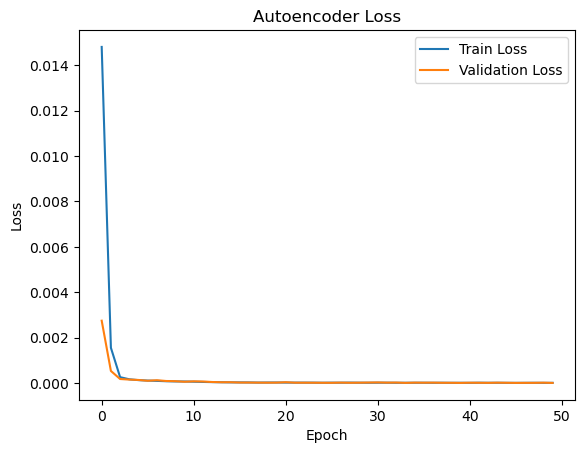

오토인코더 모델 저장 완료: autoencoder_model.h5


C:\Users\james\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
# 데이터 로드 및 전처리
# 차후 통합된 MediaPipe + SenseGlove 데이터 로드하기.
file_path = r"C:\Users\james\DATA_LAB\Hand_Tracking\hand_landmarks_with_time.csv"
data = pd.read_csv(file_path)

# 입력으로 사용할 열 선택 
# 예: MediaPipe의 X, Y, Z와 SenseGlove의 관절 데이터
# input_columns = ["X", "Y", "Z", "Joint1_Position", "Joint1_Rotation", "Joint2_Position", "Joint2_Rotation"]
# test로 x,y,z만.
input_columns = ["X", "Y", "Z"]
data = data[input_columns]

# 데이터 정규화 (0~1 범위로)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

#  데이터셋 분리 (80% 학습, 20% 테스트)
train_data, test_data = train_test_split(data_scaled, test_size=0.2, random_state=42)

# 오토인코더 모델 정의
input_dim = train_data.shape[1]  # 입력 차원

# 인코더
encoder = models.Sequential([
    layers.InputLayer(input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),  # 잠재 공간 크기
])

# 디코더
decoder = models.Sequential([
    layers.InputLayer(input_shape=(16,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='sigmoid'),  # 원래 차원 복원
])

# 오토인코더
autoencoder = models.Sequential([encoder, decoder])

# 모델 컴파일
autoencoder.compile(optimizer='adam', loss='mse')

# 모델 학습
history = autoencoder.fit(
    train_data, train_data,  # 입력과 출력이 동일
    epochs=50,
    batch_size=32,
    validation_data=(test_data, test_data),
    shuffle=True
)

# 잠재 공간 특징 추출 및 저장
# 학습된 인코더를 사용하여 잠재 공간 벡터 추출
latent_features = encoder.predict(data_scaled)

# 잠재 공간 데이터를 저장
latent_df = pd.DataFrame(latent_features, columns=[f"Latent_{i}" for i in range(latent_features.shape[1])])
latent_df.to_csv("latent_features.csv", index=False)
print("잠재 공간 특징 저장 완료: latent_features.csv")

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Autoencoder Loss')
plt.show()

# 모델 저장
autoencoder.save("autoencoder_model.h5")
print("오토인코더 모델 저장 완료: autoencoder_model.h5")